In [240]:
from datasets import load_abundance_data, get_shared_taxa_dfs
from datasets import MicroDataset, Dataset
import pandas as pd
import numpy as np
import os
dfs = load_abundance_data()
all_datasets = get_shared_taxa_dfs(dfs)

In [241]:
%config Completer.use_jedi = False

In [242]:
names = ['IBD', 'Obesity', 'Colorectal', 'EW-T2D','C-T2D', 'Cirrhosis']
#creating different groups for param sharing
groups = {
          'EU': ['IBD', 'Obesity', 'Colorectal', 'EW-T2D'],
          'CH':['C-T2D', 'Cirrhosis'], 
          'T2D':['EW-T2D','C-T2D']
        }
     

In [243]:
[(a, b.shape) for a,b in all_datasets.items()]

[('Obesity', (253, 773)),
 ('Colorectal', (121, 773)),
 ('IBD', (110, 773)),
 ('EW-T2D', (96, 773)),
 ('C-T2D', (344, 773)),
 ('Cirrhosis', (232, 773))]

In [244]:
import sys
sys.path.append('learn2learn')
from baseline.training_functions import DAE_parameters, VAE_parameters, SAE_parameters, build_DAE_eval, make_split
from Parameter_Sharing.train_param_sharing import build_sharing_encoder_eval_func
from Metalearning.MAML import MAML_FFNN_parameters, build_MAML_FFNN_eval_func

In [245]:
#setting up the best performing dataset group for each approach
just_ibd = all_datasets['Obesity']
best_share_group = 'ALL'
best_meta_group = 'EU'

share_ds = [all_datasets[g] for g in names]
meta_ds = [all_datasets[g] for g in groups['EU']]

# setting up best parameters, as reported in the reuslts csvs
stand_params = [1024, 32, 'svm']
share_params = [64, 4, 'svm']
meta_params = [0.0494584468215704, 0.07376827811002731, 1024, 64, 32, 0.3, 1]

best_share_params = {q['name']:w for q,w in zip( [a for a in VAE_parameters if a['type'] == 'choice' ],
                            share_params) }

best_stand_params = {q['name']:w for q,w in zip( [a for a in DAE_parameters if a['type'] == 'choice' ],
                            stand_params) }



best_meta_params = {q['name']:w for q,w in zip( [a for a in MAML_FFNN_parameters if a['type'] == 'choice' ] + \
                            [a for a in MAML_FFNN_parameters if a['type'] == 'range' ],
                            meta_params[2:] + meta_params[:2]) }




In [246]:
def build_eval_funcs(seed=0, is_marker=False, return_model=False):
    np.random.seed(seed) 
    #make data splits
    splits = [make_split(df) for df in meta_ds]
    #do a train/val/test split for the first dataset
    np.random.seed(seed)
    train, test = make_split(meta_ds[0])

#     train = train.sample(frac=frac) # sampling our training set
    train, valid = make_split(train)

    splits[0] = (train, valid)

    trains =  [s[0] for s in splits]
    vals =  [s[1] for s in splits]

    MAML_eval_func = build_MAML_FFNN_eval_func(train, 
                                          valid, 
                                          test,
                                          all_trains=trains, 
                                          all_valids=vals, 
                                          is_marker=is_marker,
                                          return_model=return_model
                                          )

    share_trains = pd.concat( [s[0] for s in splits], axis=0 ).reset_index(drop=True)
    share_vals = pd.concat( [s[1] for s in splits], axis=0 ).reset_index(drop=True)

    share_eval_func = build_sharing_encoder_eval_func(train, 
                                                valid, 
                                                test,
                                                all_trains=share_trains, 
                                                all_valids=share_vals, 
                                                is_marker=is_marker,
                                                model_name = 'VAE',
                                                return_model=return_model
                                                )

    #build evaluation functions
    stand_eval_func = build_DAE_eval(train, valid, test, return_model=return_model)
    return(stand_eval_func, share_eval_func, MAML_eval_func, test )

In [266]:
stand_out = [0]
share_out [0]
meta_out = [0]
for seed in range(1, 5):
    stand, share, maml, test_df = build_eval_funcs(seed=123, return_model=True)
    np.random.seed(seed)
    stand_out_ = stand(best_stand_params)
    share_out_ = share( best_share_params )
    meta_out_ = maml(best_meta_params)
    print(stand_out_[0], share_out_[0], meta_out_[0] )
    
    if stand_out[0] < stand_out_[0]:
        stand_out = stand_out_
        
    if share_out[0] < share_out_[0]:
        share_out = share_out_
        
    if meta_out[0] < meta_out_[0]:
        meta_out = meta_out_

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-21 18:11:22] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 18:11:22] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 18:11:22] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 18:11:23] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 18:11:23] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 18:11:23] ax.service.managed

0.7411764705882353 0.42352941176470593 0.5882352941176471


[INFO 04-21 18:12:30] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 18:12:30] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 18:12:30] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 18:12:31] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 18:12:31] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 18:12:31] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 18:12:31] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.7411764705882353 0.36470588235294116 0.6352941176470588


[INFO 04-21 18:13:54] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 18:13:54] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 18:13:54] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 18:13:54] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 18:13:54] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 18:13:54] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 18:13:54] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 18:13:55] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 18:13:55] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 18:13:55] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 18:13:55] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 18:13:55] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.38823529411764707 0.47058823529411764 0.45882352941176474


[INFO 04-21 18:15:05] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 18:15:05] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 18:15:05] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.28235294117647064 0.4941176470588235 0.45882352941176474


In [270]:
best_share_params

{'layer_1_size': 64, 'layer_2_size': 4, 'classifier_model': 'svm'}

In [267]:
stand_out[0]

0.7411764705882353

In [268]:
share_out[0]

0.776470588235294

In [ ]:
plt.savefig()

In [269]:
meta_out[0]

0.6352941176470588

In [284]:
test_input_tensor = test_dataset.matrix

In [336]:
test_dataset

In [ ]:
q.attribute()

In [360]:
def get_model_attribution(forward_func, test_dataset):
    dim_out = forward_func(torch.zeros(size=(1,771))).shape[1]
    ig = Saliency(forward_func)

    test_input_tensor = test_dataset.matrix
    test_input_tensor.requires_grad_()
    
    
    attrs =  [ ig.attribute(test_input_tensor, target=i) for i in range(dim_out) ]
    return(attrs)

In [357]:
models = stand_out[1][0].eval(), share_out[1][0].eval(), meta_out[1].eval()
forward_funcs = [lambda x:torch.Tensor( models[0].model.encode(x)),
                 lambda x:torch.Tensor( models[1].model.encode(x)),
                 lambda x:torch.Tensor( models[2](x)),
                ]

attribz = [get_model_attribution(f, test_dataset) for f in forward_funcs]

In [358]:
impzz = [torch.stack(a).abs().mean(dim=0).mean(dim=0).detach().numpy() for a in attribz]

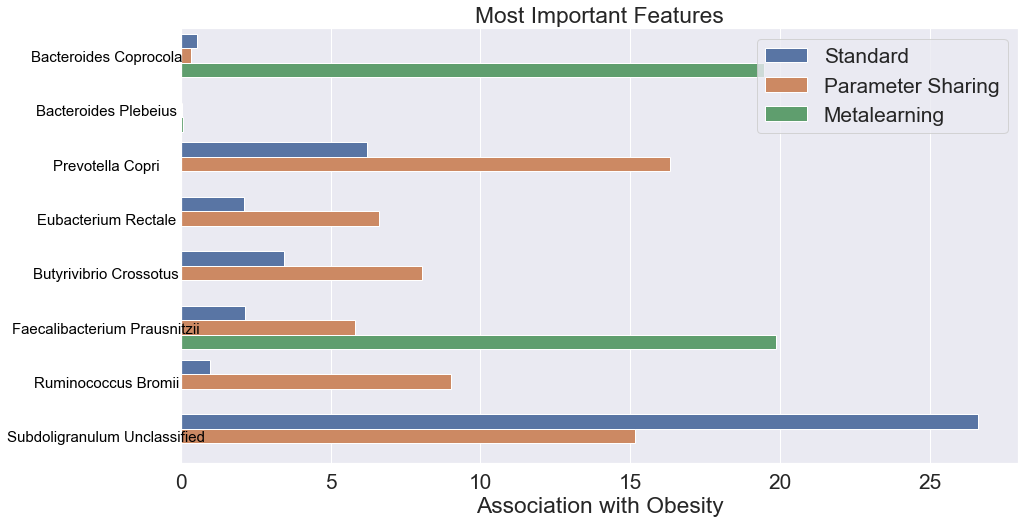

In [364]:
show_importances(impzz)

In [363]:
def show_importances(impzz, feature_names=feature_names):
    n_feats = 4
    feats = np.unique( np.hstack( [np.argsort(np.abs(imp))[::-1][:n_feats] for imp in impzz] ) )
    n_used = len(feats)
    names = ['Standard', 'Parameter Sharing', 'Metalearning']

    plot_df = pd.concat( [pd.DataFrame( {'Importance':a[feats] , 'Training Type':n_used*[names[i]], 
                                        'Taxon':feature_names[feats]} )
                  for i,a in enumerate([imp/np.std(imp) for imp in impzz])], axis = 0 ) #imp/np.std(imp)

    sns.set_theme()
    sns.set(font_scale = 1.9)
    sns.set_style("darkgrid")

    # pal = sns.color_palette("RdBu", n_used)
    # rank = lr.coef_.flatten()[0:7].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
    # #sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

    # qq=np.hstack(coefs[:7])
    fig = plt.figure(figsize=(15, 8))
    g=sns.barplot(y = 'Taxon', x = 'Importance', hue='Training Type', data= plot_df,
                   orient = 'h')
    plt.xticks(None)

    for i in range( n_used ):
        g.text(-2.5, i + .1  ,
               ' '.join( [a.capitalize() for a in feature_names[feats[i]].split('_')]),
               color='black', ha="center", rotation = 0, size = 15)

    plt.yticks(ticks=np.arange(0, 7, 1),
               labels =  [' '] * 7,#list( feast_taxa_info.iloc[ qq ].species.values), 
              rotation=45)
    plt.ylabel(None)
    # plt.yticks(ticks=np.arange(0, 5, 1),
    #            labels =  list( feast_taxa_info.iloc[ qq ].species.values), 
    #           rotation=45)
    plt.legend(loc = 'upper right')
    plt.title("Most Important Features")
    plt.xlabel('Association with Obesity')
    return(g)



In [312]:
forward_func = lambda x: share_out[1][0].model.encode(x)
dim = forward_func(torch.zeros(size=(1,771))).shape[1]
q = Saliency(forward_func)

torch.cat( [q.attribute(test_input_tensor, target=i) for i in range(q)] )
# q.attribute(Inte, target=2, return_convergence_delta=False, 
#             attribute_to_layer_input= True)

torch.Size([22, 771])

In [279]:
share_out[1][0].model

VAE(
  (encoder_l1): Sequential(
    (0): Linear(in_features=771, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_mu): Linear(in_features=64, out_features=4, bias=True)
  (encoder_logsigma): Linear(in_features=64, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=771, bias=True)
    (3): ReLU()
    (4): Softmax(dim=None)
  )
  (softplus): Softplus(beta=1, threshold=20)
)

In [274]:
test_dataset = MicroDataset(test_df)
get_model_inference(share_out[1][0], 2, test_dataset)

[tensor([[-6.2080e-14, -3.8944e-12, -8.9011e-13,  ...,  1.4983e-12,
           1.0307e-11, -1.6099e-13],
         [-1.8645e-13, -5.2008e-13,  1.9092e-12,  ...,  3.4961e-13,
           1.1318e-12,  9.9546e-13],
         [ 1.0367e-33, -6.6857e-33,  8.3893e-33,  ...,  5.4752e-33,
           6.9134e-33,  6.0471e-33],
         ...,
         [ 2.7354e-12,  1.1978e-11,  4.3959e-11,  ..., -2.3426e-11,
          -6.6514e-12, -2.2515e-11],
         [-1.1427e-15,  2.9677e-15,  1.1749e-15,  ..., -2.3147e-15,
           3.1512e-15, -2.8612e-15],
         [-2.8621e-20, -2.0624e-19, -1.0470e-20,  ...,  7.3079e-20,
           4.5055e-19, -7.7006e-20]], dtype=torch.float64,
        grad_fn=<MulBackward0>),
 tensor([[-4.9409e-13, -4.6070e-12, -8.5702e-13,  ...,  1.4779e-12,
           1.1415e-11, -1.3310e-12],
         [-2.2308e-13, -5.9225e-13,  1.9382e-12,  ...,  3.9251e-13,
           1.2044e-12,  1.1537e-12],
         [ 4.7455e-34, -8.3419e-33,  8.3718e-33,  ...,  8.3251e-33,
           9.6349e-33, 

In [ ]:
def get_model_inference(model, dim_out, test_dataset):
    model.eval()
#     if layer is None:
#         ig = IntegratedGradients(model)
#     else:
#         ig = LayerGradientShap(model, layer)
        
    ig = IntegratedGradients(model)

    test_input_tensor = test_dataset.matrix
    test_input_tensor.requires_grad_()
    
    
    attrs =  [ ig.attribute(test_input_tensor,target=i, return_convergence_delta=False)
                    for i in range(dim_out) ]
    return(attrs)
    
    

In [ ]:
explain_models(stand_out, share_out, meta_out):
    imps = [ get_model_inference(mod, layer, test_dataset) \
         for (mod, layer) in zip( [stand_out[1][0], share_out[1][0], meta_out[1]], 
                                 [32, 128, 2 ])]

In [6]:
names = ['IBD', 'Obesity', 'Colorectal', 'EW-T2D','C-T2D', 'Cirrhosis']
#creating different groups for param sharing
groups = {
          'EU': ['Obesity', 'IBD', 'Colorectal', 'EW-T2D'],
          'CH':['C-T2D', 'Cirrhosis'], 
          'T2D':['EW-T2D','C-T2D']
        }
     

#setting up the best performing dataset group for each approach
just_obes = all_datasets['Obesity']
best_share_group = 'EU'
best_meta_group = 'EU'

share_ds = [all_datasets[g] for g in groups['EU']]
meta_ds = [all_datasets[g] for g in groups['EU']]

# setting up best parameters, as reported in the reuslts csvs
stand_params = [128, 'svm']
share_params = [256, 32, 'rf']
meta_params = [0.014412704342603683, 0.013474401043355465, 256, 256, 128, 0.3, 16]

best_share_params = {q['name']:w for q,w in zip( [a for a in DAE_parameters if a['type'] == 'choice' ],
                            share_params) }

best_stand_params = {q['name']:w for q,w in zip( [a for a in SAE_parameters if a['type'] == 'choice' ],
                            stand_params) }



best_meta_params = {q['name']:w for q,w in zip( [a for a in MAML_FFNN_parameters if a['type'] == 'choice' ] + \
                            [a for a in MAML_FFNN_parameters if a['type'] == 'range' ],
                            meta_params[2:] + meta_params[:2]) }




In [7]:
def build_eval_funcs(seed=0, is_marker=False, return_model=False):
    np.random.seed(seed) 
    #make data splits
    splits = [make_split(df) for df in meta_ds]
    #do a train/val/test split for the first dataset
    np.random.seed(seed)
    train, test = make_split(meta_ds[0])

#     train = train.sample(frac=frac) # sampling our training set
    train, valid = make_split(train)

    splits[0] = (train, valid)

    trains =  [s[0] for s in splits]
    vals =  [s[1] for s in splits]

    MAML_eval_func = build_MAML_FFNN_eval_func(train, 
                                          valid, 
                                          test,
                                          all_trains=trains, 
                                          all_valids=vals, 
                                          is_marker=is_marker,
                                          return_model=return_model
                                          )

    np.random.seed(seed) 
    #make data splits
    splits = [make_split(df) for df in share_ds] # using different set of data to transfer info
    #do a train/val/test split for the first dataset

    np.random.seed(seed)
    train, test = make_split(share_ds[0])

#     train = train.sample(frac=frac) # sampling our training set
    train, valid = make_split(train)

    splits[0] = (train, valid)

    share_trains = pd.concat( [s[0] for s in splits], axis=0 ).reset_index(drop=True)
    share_vals = pd.concat( [s[1] for s in splits], axis=0 ).reset_index(drop=True)

    share_eval_func = build_sharing_encoder_eval_func(train, 
                                                valid, 
                                                test,
                                                all_trains=share_trains, 
                                                all_valids=share_vals, 
                                                is_marker=is_marker,
                                                model_name = 'DAE',
                                                return_model=return_model
                                                )

    #build evaluation functions
    stand_eval_func = build_DAE_eval(train, valid, test, return_model=return_model, model_name='SAE')
    return(stand_eval_func, share_eval_func, MAML_eval_func, test)

In [209]:
stand, share, maml, test_df = build_eval_funcs(seed=0, return_model=True)
np.random.seed(1)
stand_out = stand(best_stand_params)
share_out = share( best_share_params )
meta_out = maml(best_meta_params)

for i in range(4):
    np.random.seed(i+2)
    print(i)
    # run 4 iterations, take the best model
    stand_out_ = stand(best_stand_params)
    share_out_ = share( best_share_params )
    meta_out_ = maml(best_meta_params)
    
    if stand_out[0] < stand_out_[0]:
        stand_out = stand_out_
        
    if share_out[0] < share_out_[0]:
        share_out = share_out_
        
    if meta_out[0] < meta_out_[0]:
        meta_out = meta_out_

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-20 23:48:16] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 23:48:16] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 23:48:16] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 23:48:17] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 23:48:17] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 23:48:17] ax.service.managed

0


[INFO 04-20 23:53:38] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 23:53:38] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 23:53:38] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 23:53:38] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 23:53:39] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

1


[INFO 04-20 23:58:41] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 23:58:41] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 23:58:41] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 23:58:41] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 23:58:41] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 23:58:42] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

2


[INFO 04-21 00:03:10] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:03:10] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:03:10] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:03:11] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:03:12] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 00:03:12] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

3


[INFO 04-21 00:08:40] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:08:40] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:08:40] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:08:40] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:08:40] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 00:08:41] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

In [224]:
for i in range(6, 20):
    stand, share, maml, test_df = build_eval_funcs(seed=i, return_model=True)

    np.random.seed(i)
    
    share_out_ = share( best_share_params )
    print(share_out[0])
    if share_out[0] < share_out_[0]:
            share_out = share_out_
        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-21 00:44:26] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:44:26] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:44:26] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:44:28] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:44:32] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:44:35] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:44:40] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:44:47] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:44:53] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:44:54] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:44:57] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 00:45:03] ax.service.managed

0.597750865051903


[INFO 04-21 00:45:33] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:45:33] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:45:33] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:45:34] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:45:36] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:45:42] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:45:48] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:45:51] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:45:58] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:46:02] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:46:06] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 00:46:07] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6000000000000001


[INFO 04-21 00:46:27] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:46:27] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:46:27] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:46:29] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:46:35] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:46:36] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:46:42] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:46:48] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:46:53] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:46:58] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:47:03] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 00:47:06] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6111111111111112


[INFO 04-21 00:47:22] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 00:47:22] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 00:47:22] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 00:47:24] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 00:47:26] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 00:47:28] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 00:47:29] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 00:47:33] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 00:47:37] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 00:47:43] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 00:47:44] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 08:45:02] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


[INFO 04-21 10:23:31] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:23:31] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:23:31] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:23:39] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:23:41] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:23:50] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:23:51] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:23:55] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:23:58] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:24:01] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:24:02] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:24:06] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


[INFO 04-21 10:24:24] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:24:24] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:24:24] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:24:27] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:24:31] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:24:36] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:24:40] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:24:46] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:24:50] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:24:54] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:24:57] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:25:02] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


[INFO 04-21 10:25:12] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:25:12] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:25:12] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:25:12] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:25:16] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:25:16] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:25:20] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:25:22] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:25:31] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:25:33] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:25:35] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:25:39] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
[INFO 04-21 10:25:47] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:25:47] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:25:47] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:25:51] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:25:51] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:25:57] ax.service.managed_loop: Running optimization t

0.6629554655870445


[INFO 04-21 10:26:33] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:26:33] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:26:33] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:26:35] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:26:40] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:26:42] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:26:44] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:26:48] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:26:53] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:26:56] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:26:57] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:27:00] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


[INFO 04-21 10:27:10] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:27:10] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:27:10] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:27:16] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:27:23] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:27:25] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:27:26] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:27:31] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:27:32] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:27:33] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:27:35] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:27:40] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

0.6629554655870445


[INFO 04-21 10:27:50] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:27:50] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:27:50] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:27:57] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:27:59] ax.service.managed_loop: Running optimization trial 3...


KeyboardInterrupt: 

In [227]:
for seed in range(1, 10):
    stand, share, maml, test_df = build_eval_funcs(seed=seed, return_model=True)
    np.random.seed(seed)
    stand_out = stand(best_stand_params)
    share_out = share( best_share_params )
    meta_out = maml(best_meta_params)
    print(seed)
    print(stand_out[0], share_out[0], meta_out[0])



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-21 10:35:42] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:35:42] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:35:42] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:35:43] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:35:44] ax.service.managed

1
0.5619047619047619 0.5309523809523811 0.523015873015873


[INFO 04-21 10:40:45] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:40:45] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:40:45] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:40:45] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:40:45] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:40:45] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:40:46] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

2
0.4333881578947369 0.5476973684210527 0.6398026315789473


[INFO 04-21 10:45:51] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:45:51] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:45:51] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:45:51] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:45:52] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:45:53] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

3
0.6482142857142857 0.5410714285714285 0.5169642857142857


[INFO 04-21 10:51:37] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:51:37] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:51:37] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:51:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:51:38] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:51:38] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:51:38] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

4
0.6298387096774193 0.4862903225806452 0.5758064516129032


[INFO 04-21 10:57:05] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 10:57:05] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 10:57:05] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 10:57:06] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 10:57:06] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 10:57:06] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 10:57:06] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

5
0.5951557093425606 0.6245674740484429 0.5285467128027682


[INFO 04-21 11:01:59] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 11:01:59] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 11:01:59] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 11:02:00] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 11:02:00] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 11:02:00] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 11:02:00] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

6
0.5267857142857142 0.5678571428571428 0.5839285714285715


[INFO 04-21 11:07:37] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 11:07:37] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 11:07:37] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 11:07:37] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 11:07:37] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 11:07:37] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 11:07:38] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

7
0.4476190476190476 0.5476190476190477 0.6404761904761904


[INFO 04-21 11:13:24] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 11:13:24] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 11:13:24] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 11:13:24] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 11:13:24] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 11:13:24] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 11:13:25] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

8
0.4493927125506073 0.5495951417004049 0.6568825910931174


[INFO 04-21 11:18:58] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-21 11:18:58] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-21 11:18:58] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-21 11:18:58] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-21 11:18:58] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-21 11:18:58] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-21 11:18:59] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

9
0.544407894736842 0.5509868421052632 0.6356907894736842


In [228]:
print( stand_out[0] )
print( share_out[0] )
print(  meta_out[0] )

0.544407894736842
0.5509868421052632
0.6356907894736842


In [210]:
print( stand_out[0] )
print( share_out[0] )
print(  meta_out[0] )

0.6626297577854671
0.588235294117647
0.7811418685121106


In [289]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from captum.attr import NeuronIntegratedGradients
from captum.attr import InternalInfluence
from captum.attr import LayerIntegratedGradients
from captum.attr import LayerGradientShap
from captum.attr import Saliency

In [367]:
from Inference import inference

In [379]:
import imp
imp.reload(inference)

<module 'Inference.inference' from '/Users/george/Desktop/MLFG_Project/Inference/inference.py'>

([<matplotlib.axis.XTick at 0x1a52c4a358>],
 <a list of 1 Text xticklabel objects>)

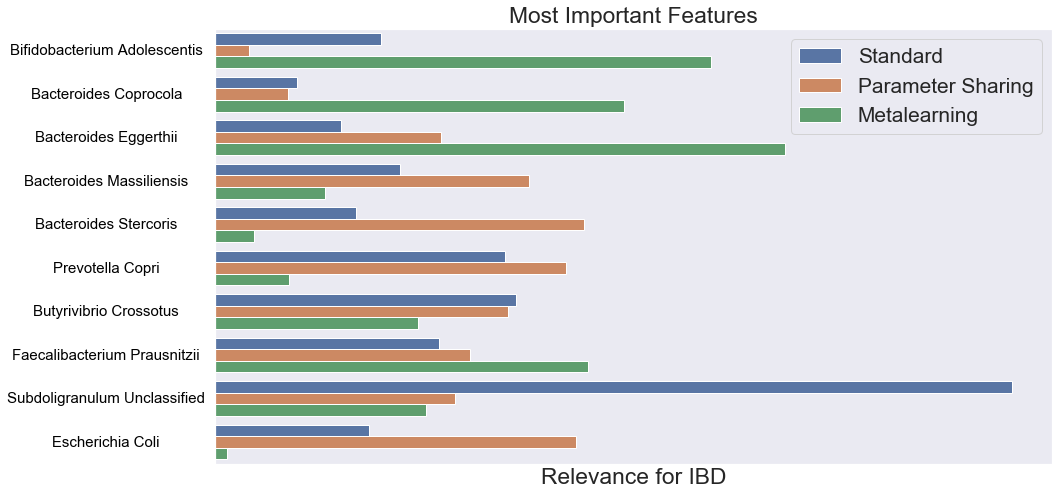

In [385]:
g = inference.summarize_models(stand_out, share_out, meta_out, test_df)
plt.xticks([-3])
# plt.title(None)
# plt.savefig('figures/IBD_Inference.png')

<Figure size 432x288 with 0 Axes>

In [75]:
# ig = IntegratedGradients(meta_out[1].model)
ig = IntegratedGradients(stand_out[1][0].model)

In [76]:
test_dataset = MicroDataset(test_df)

In [111]:
stand_out[1][0].model.encoder

Sequential(
  (0): Linear(in_features=771, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
)

In [113]:
share_out[1][0].model.encoder

Sequential(
  (0): Linear(in_features=771, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=32, bias=True)
  (4): ReLU()
)

In [ ]:
share_out[1]

In [162]:
[p for p in stand_out[1][0].model.encoder[0].parameters()][0].shape

torch.Size([128, 771])

In [ ]:
explain_models(stand_out, share_out, meta_out):
    imps = [ get_model_inference(mod, layer, test_dataset) \
         for (mod, layer) in zip( [stand_out[1][0], share_out[1][0], meta_out[1]], 
                                 [32, 128, 2 ])]

In [229]:
def get_model_inference(model, dim_out, test_dataset):
    model.eval()
#     if layer is None:
#         ig = IntegratedGradients(model)
#     else:
#         ig = LayerGradientShap(model, layer)
        
    ig = IntegratedGradients(model)

    test_input_tensor = test_dataset.matrix
    test_input_tensor.requires_grad_()
    
    
    attrs =  [ ig.attribute(test_input_tensor,target=i, return_convergence_delta=False)
                    for i in range(dim_out) ]
    return(attrs)
    

In [133]:
imps[-1].shape

(771,)

In [234]:
imps = [ get_model_inference(mod, layer, test_dataset) \
         for (mod, layer) in zip( [stand_out[1][0], share_out[1][0], meta_out[1]], 
                                 [32, 128, 2 ])]

In [235]:
impzz = [torch.stack(a).abs().mean(dim=0).mean(dim=0).detach().numpy() for a in imps]

In [236]:
imps = [ np.mean( get_model_inference(mod, layer, test_dataset), axis = 0) \
         for (mod, layer) in zip( [stand_out[1][0], share_out[1][0], meta_out[1]], 
                                 [stand_out[1][0].model.encoder, share_out[1][0].model.encoder, None ])]

TypeError: 'Sequential' object cannot be interpreted as an integer

In [231]:
feature_names = test_df.columns[test_df.columns.str.contains('k__')].str.split('__').str[-1]

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

In [237]:
n_feats = 4
feats = np.unique( np.hstack( [np.argsort(np.abs(imp))[::-1][:n_feats] for imp in impzz] ) )
n_used = len(feats)
names = ['Standard', 'Parameter Sharing', 'Metalearning']

plot_df = pd.concat( [pd.DataFrame( {'Importance':a[feats] , 'Training Type':n_used*[names[i]], 
                                    'Taxon':feature_names[feats]} )
              for i,a in enumerate([imp/np.std(imp) for imp in impzz])], axis = 0 )

sns.set_theme()
sns.set(font_scale = 1.9)
sns.set_style("darkgrid")

# pal = sns.color_palette("RdBu", n_used)
# rank = lr.coef_.flatten()[0:7].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
# #sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

# qq=np.hstack(coefs[:7])
fig = plt.figure(figsize=(15, 8))
g=sns.barplot(y = 'Taxon', x = 'Importance', hue='Training Type', data= plot_df,
               orient = 'h')
plt.xticks(None)

for i in range( n_used ):
    g.text(-2.5, i + .1  ,
           ' '.join( [a.capitalize() for a in feature_names[feats[i]].split('_')]),
           color='black', ha="center", rotation = 0, size = 15)

plt.yticks(ticks=np.arange(0, 7, 1),
           labels =  [' '] * 7,#list( feast_taxa_info.iloc[ qq ].species.values), 
          rotation=45)
plt.ylabel(None)
# plt.yticks(ticks=np.arange(0, 5, 1),
#            labels =  list( feast_taxa_info.iloc[ qq ].species.values), 
#           rotation=45)
plt.legend(loc = 'upper right')
plt.title("Most Important Features")
plt.xlabel('Association with Obesity')
plt.show()




In [238]:
sns.set_theme()
sns.set(font_scale = 1.9)
sns.set_style("darkgrid")

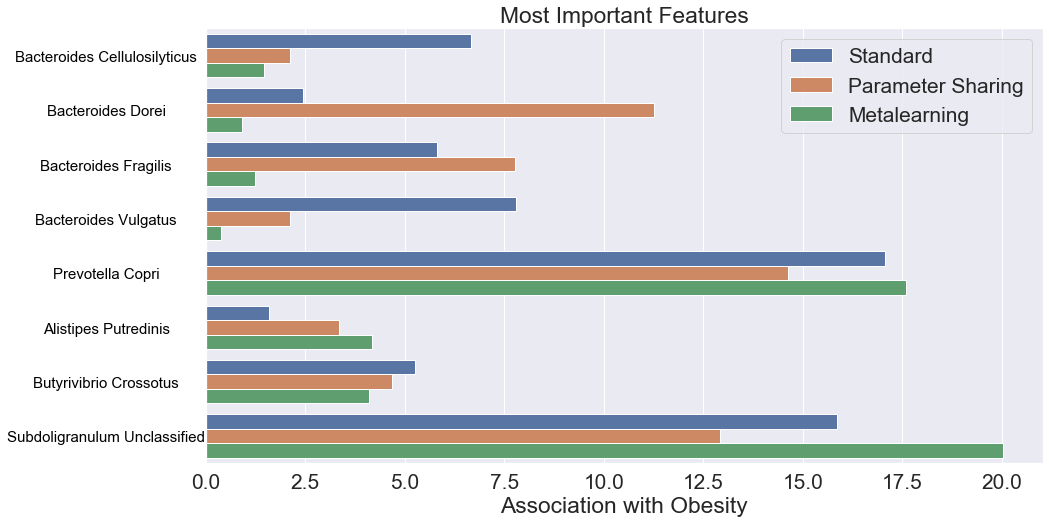

In [239]:
# pal = sns.color_palette("RdBu", n_used)
# rank = lr.coef_.flatten()[0:7].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
# #sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

# qq=np.hstack(coefs[:7])
fig = plt.figure(figsize=(15, 8))
g=sns.barplot(y = 'Taxon', x = 'Importance', hue='Training Type', data= plot_df,
               orient = 'h')
plt.xticks(None)

for i in range( n_used ):
    g.text(-2.5, i + .1  ,
           ' '.join( [a.capitalize() for a in feature_names[feats[i]].split('_')]),
           color='black', ha="center", rotation = 0, size = 15)

plt.yticks(ticks=np.arange(0, 7, 1),
           labels =  [' '] * 7,#list( feast_taxa_info.iloc[ qq ].species.values), 
          rotation=45)
plt.ylabel(None)
# plt.yticks(ticks=np.arange(0, 5, 1),
#            labels =  list( feast_taxa_info.iloc[ qq ].species.values), 
#           rotation=45)
plt.legend(loc = 'upper right')
plt.title("Most Important Features")
plt.xlabel('Association with Obesity')
plt.show()



## Doing LIME Analysis

In [10]:
print('done')

done


In [13]:
stand_out[1][0].eval()

LitEncoderDecoder(
  (model): SAE(
    (encoder): Sequential(
      (0): Linear(in_features=771, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=771, bias=True)
      (1): ReLU()
      (2): Softmax(dim=None)
    )
  )
  (loss_func): MSELoss()
)

In [14]:
mod = stand_out[1]

In [211]:
mod = meta_out[1]

In [212]:
import lime
import lime.lime_tabular
import torch

test_dataset = MicroDataset(test_df)
feature_names = test_df.columns[test_df.columns.str.contains('k__')].str.split('__').str[-1]

def explain_model_prediction(mod, test_dataset, idx=0):
    X = test_dataset.matrix.numpy()
    training_labels = test_dataset.y.numpy()

    explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                       feature_names=feature_names, 
                                                       class_names=['Lean', 'Obese'], 
                                                       verbose=True, mode='classification'
                                                      )
    if type(mod) == tuple:
        m1 = mod[0].eval()
        m2 = mod[1]
        model = lambda x: m2.predict_proba( m1(torch.Tensor(x)))


    else:
        m1 = mod.eval()
        model = lambda x: m1(torch.Tensor(x)).detach().numpy()

    idx = 0
    exp = explainer.explain_instance(X[idx] , model, num_features=10, num_samples=300)
    exp.show_in_notebook()

    return(pd.DataFrame(exp.as_list()) )

In [214]:
dd_out = explain_model_prediction(mod, test_dataset)

Intercept 0.6532642586619846
Prediction_local [0.75994306]
Right: 0.8175142


In [71]:
dd_out = explain_model_prediction(mod, test_dataset)

Intercept 0.6660514654998682
Prediction_local [0.76602682]
Right: 0.8935932


ValueError: DataFrame constructor not properly called!

In [ ]:
dd_out

In [45]:
def model(x):
    q = m1.encode(torch.Tensor(x). ).detach().numpy()
    print(q.shape)
    out = m2.predict_proba( q )
    print(out.shape)
    return(out)

In [ ]:
mod = 

In [57]:
if len(mod) == 2:
    m1 = mod[0].model.eval()
    m2 = mod[1]
    model = lambda x: m2.predict_proba( m1.encode(torch.Tensor(x) ).detach().numpy())
    
    
else:
    model = lambda x: mod[1](torch.Tensor(x).unsqueeze(0).detach())

idx = 0
exp = explainer.explain_instance(X, model, num_features=10, num_samples=300)
exp.show_in_notebook()



ValueError: could not broadcast input array from shape (51,771) into shape (51)

In [54]:
pd.DataFrame( exp.as_list() )

0         1
0                     Eubacterium_rectale <= 0.00 -0.031005
1                 Cronobacter_malonaticus <= 0.00 -0.029925
2               Oscillibacter_sp_KLE_1745 <= 0.00 -0.029195
3                Clostridium_sp_7_2_43FAA <= 0.00  0.020013
4               Corynebacterium_variabile <= 0.00 -0.015916
5                   Holdemania_filiformis <= 0.00 -0.015053
6  Bacteroidetes_bacterium_oral_taxon_272 <= 0.00 -0.014406
7                     Clostridium_ramosum <= 0.00  0.012764
8                    Pantoea_unclassified <= 0.00 -0.006701
9                Bacteroides_salanitronis <= 0.00  0.006400

In [55]:
test_df.shape

(51, 773)

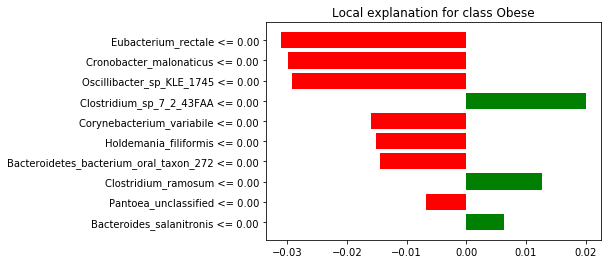

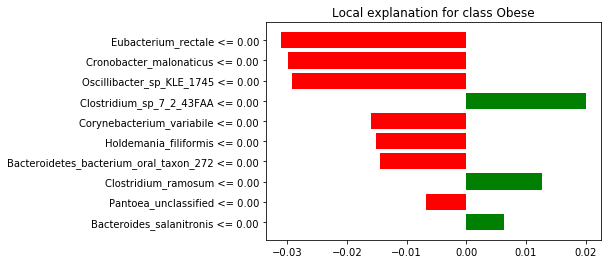

In [51]:
exp.as_pyplot_figure()

In [19]:
test_dataset.y

tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1])

In [237]:
plt.figure(figsize = (12, 7) )
 

<Figure size 864x504 with 0 Axes>

<Figure size 864x504 with 0 Axes>

Average Feature Importances
Subdoligranulum_unclassified :  -0.000
Prevotella_copri :  -0.000
Eubacterium_rectale :  -0.000
Butyrivibrio_crossotus :  -0.000
Faecalibacterium_prausnitzii :  -0.000
Bacteroides_plebeius :  0.000


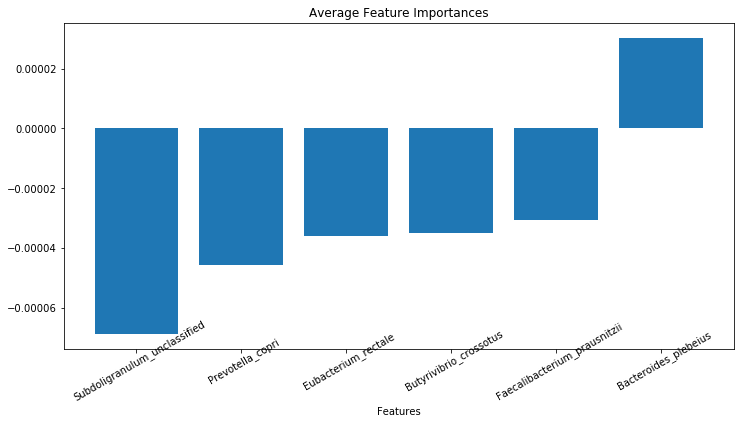

In [145]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, 
                          title="Average Feature Importances", 
                          plot=True, 
                          axis_title="Features", 
                          n_feats = 6):
    print(title)
    feats = np.argsort( np.abs( np.mean(attr, axis=0) ))[::-1][:n_feats]
    for i in range(len(feats)):
        print(feature_names[feats[i]], ": ", '%.3f'%(importances[feats[i]]))
    x_pos = (np.arange(len(feature_names[feats])))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances[feats], align='center')
        plt.xticks(x_pos, feature_names[feats], wrap=True, rotation=30)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

In [71]:
(meta_out[1](test_dataset.matrix)[:, 1] > .1 ) == test_dataset.y

tensor([False, False, False, False, False,  True,  True,  True, False, False,
        False, False, False,  True, False, False,  True,  True, False, False,
        False, False])

In [65]:
test_dataset.y

tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [63]:
attr.shape

(22, 771)

In [52]:
meta_out[1].model

FFNN(
  (linear_net): Sequential(
    (0): Linear(in_features=771, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): GELU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): GELU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): GELU()
    (12): Linear(in_features=128, out_features=2, bias=True)
    (13): Softmax(dim=None)
  )
)

In [33]:
stand_out[1][0]

LitEncoderDecoder(
  (model): SAE(
    (encoder): Sequential(
      (0): Linear(in_features=771, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=771, bias=True)
      (1): ReLU()
      (2): Softmax(dim=None)
    )
  )
  (loss_func): MSELoss()
)

In [45]:
import captum

In [46]:
captum

<module 'captum' from '/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/captum/__init__.py'>

In [48]:
%config Completer.use_jedi = False